In [24]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt
import json
import requests
import pickle
import gzip as gz

import sys
sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/src/')
from CellType_PSY import *

In [16]:
def SaveDict(Dict, fname):
    with open(fname, 'wb') as hand:
        pickle.dump(Dict, hand)
    return

def LoadDict(fname):
    with open(fname, 'rb') as hand:
        b = pickle.load(hand)
        return b


# Make Cell Type Meta

In [113]:
cell_extended = pd.read_csv("dat/cell_metadata_with_cluster_annotation.csv")

/tmp/ipykernel_669752/2665016588.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_extended = pd.read_csv("dat/cell_metadata_with_cluster_annotation.csv")


In [114]:
label="class"
groupnames = cell_extended[label].unique()
group2barcode = {}
for groupname in groupnames:
    tmpdf = cell_extended[cell_extended[label]==groupname]
    group2barcode[groupname] = tmpdf["cell_barcode"].values

In [115]:
groupnames.sort()
groupnames

array(['01 IT-ET Glut', '02 NP-CT-L6b Glut', '03 OB-CR Glut',
       '04 DG-IMN Glut', '05 OB-IMN GABA', '06 CTX-CGE GABA',
       '07 CTX-MGE GABA', '08 CNU-MGE GABA', '09 CNU-LGE GABA',
       '10 LSX GABA', '11 CNU-HYa GABA', '12 HY GABA', '13 CNU-HYa Glut',
       '14 HY Glut', '15 HY Gnrh1 Glut', '16 HY MM Glut', '17 MH-LH Glut',
       '18 TH Glut', '19 MB Glut', '20 MB GABA', '21 MB Dopa',
       '22 MB-HB Sero', '23 P Glut', '24 MY Glut', '25 Pineal Glut',
       '26 P GABA', '27 MY GABA', '28 CB GABA', '29 CB Glut',
       '30 Astro-Epen', '31 OPC-Oligo', '32 OEC', '33 Vascular',
       '34 Immune'], dtype=object)

In [116]:
label="cluster"
groupnames = cell_extended[label].unique()
groupnames.sort()

In [117]:
groupnames

array(['0001 CLA-EPd-CTX Car3 Glut_1', '0002 CLA-EPd-CTX Car3 Glut_1',
       '0003 CLA-EPd-CTX Car3 Glut_1', ..., '5320 ILC NN_2',
       '5321 NK cells NN_3', '5322 T cells NN_4'], dtype=object)

In [118]:
label="subclass"
groupnames = cell_extended[label].unique()
groupnames.sort()
groupnames

array(['001 CLA-EPd-CTX Car3 Glut', '002 IT EP-CLA Glut',
       '003 L5/6 IT TPE-ENT Glut', '004 L6 IT CTX Glut',
       '005 L5 IT CTX Glut', '006 L4/5 IT CTX Glut',
       '007 L2/3 IT CTX Glut', '008 L2/3 IT ENT Glut',
       '009 L2/3 IT PIR-ENTl Glut', '010 IT AON-TT-DP Glut',
       '011 L2 IT ENT-po Glut', '012 MEA Slc17a7 Glut',
       '013 COAp Grxcr2 Glut', '014 LA-BLA-BMA-PA Glut',
       '015 ENTmv-PA-COAp Glut', '016 CA1-ProS Glut', '017 CA3 Glut',
       '018 L2 IT PPP-APr Glut', '019 L2/3 IT PPP Glut',
       '020 L2/3 IT RSP Glut', '021 L4 RSP-ACA Glut',
       '022 L5 ET CTX Glut', '023 SUB-ProS Glut', '024 L5 PPP Glut',
       '025 CA2-FC-IG Glut', '026 NLOT Rho Glut', '027 L6b EPd Glut',
       '028 L6b/CT ENT Glut', '029 L6b CTX Glut', '030 L6 CT CTX Glut',
       '031 CT SUB Glut', '032 L5 NP CTX Glut', '033 NP SUB Glut',
       '034 NP PPP Glut', '035 OB Eomes Ms4a15 Glut', '036 HPF CR Glut',
       '037 DG Glut', '038 DG-PIR Ex IMN', '039 OB Meis2 Thsd7b Gaba',


In [119]:
cell_extended.head(5)

,Unnamed: 0,cell_label,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,...,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color,region_of_interest_order,region_of_interest_color
0,0,GCGAGAAGTTAAGGGC-410_B05,GCGAGAAGTTAAGGGC,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
1,1,AATGGCTCAGCTCCTT-411_B06,AATGGCTCAGCTCCTT,411_B06,L8TX_201029_01_E10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
2,2,AACACACGTTGCTTGA-410_B05,AACACACGTTGCTTGA,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
3,3,CACAGATAGAGGCGGA-410_A05,CACAGATAGAGGCGGA,410_A05,L8TX_201029_01_A10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
4,4,AAAGTGAAGCATTTCG-410_B05,AAAGTGAAGCATTTCG,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C


In [120]:
feature_matrix_label = cell_extended["feature_matrix_label"].unique()
sub_meta_dict = {}
for feature_label in feature_matrix_label:
    sub_feature_meta = cell_extended[cell_extended["feature_matrix_label"]==feature_label]
    sub_meta_dict[feature_label] = sub_feature_meta
    sub_feature_meta.to_csv("dat/Cell_Meta_Splited/{}.meta.csv".format(feature_label))

In [121]:
feature_matrix_label

array(['WMB-10Xv3-HPF', 'WMB-10Xv3-Isocortex-1', 'WMB-10Xv3-PAL',
       'WMB-10Xv3-STR', 'WMB-10Xv3-CTXsp', 'WMB-10Xv3-HY',
       'WMB-10Xv3-OLF', 'WMB-10Xv3-TH', 'WMB-10Xv3-P', 'WMB-10Xv3-MB',
       'WMB-10Xv3-MY', 'WMB-10Xv3-CB', 'WMB-10Xv3-Isocortex-2',
       'WMB-10Xv2-HPF', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-HY',
       'WMB-10Xv2-TH', 'WMB-10Xv2-OLF', 'WMB-10Xv2-CTXsp', 'WMB-10Xv2-MB',
       'WMB-10Xv2-Isocortex-2', 'WMB-10Xv2-Isocortex-3',
       'WMB-10Xv2-Isocortex-4', 'WMB-10XMulti'], dtype=object)

In [122]:
fillist = "/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/10X-SC-FileList.txt"

In [123]:
flist = [l.strip() for l in open(fillist, 'rt').readlines()]

In [127]:
import csv
fout = csv.writer(open("dat/ExpMat_Feature_Meta.tsv", 'wt'))
for expfil in flist:
    print(expfil)
    fname = expfil.split("/")[-1]
    feature_label = fname.replace("-log2.h5ad", "")
    if feature_label not in sub_meta_dict:
        print(feature_label)
    fout.writerow([expfil, feature_label, 
    "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Cell_Meta_Splited/{}.meta.csv".format(feature_label)])         

/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10XMulti/20230830/WMB-10XMulti-log2.h5ad
/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-CTXsp-log2.h5ad
/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-Isocortex-4-log2.h5ad
/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-TH-log2.h5ad
/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-HY-log2.h5ad
/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-OLF-log2.h5ad
/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-Isocortex-1-log2.h5ad
/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas

## Combine Feature seperated data (Mean)

In [73]:
Split_Exp_Dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/AggregatedExpMat/"

In [74]:
feature_matrix_label_v2 = [x for x in feature_matrix_label if 'v2' in x]
feature_matrix_label_v3 = [x for x in feature_matrix_label if 'v3' in x]
feature_matrix_label_Multi = [x for x in feature_matrix_label if 'Multi' in x]

In [75]:
print(feature_matrix_label_v2)
print(feature_matrix_label_v3)
print(feature_matrix_label_Multi)

['WMB-10Xv2-HPF', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-HY', 'WMB-10Xv2-TH', 'WMB-10Xv2-OLF', 'WMB-10Xv2-CTXsp', 'WMB-10Xv2-MB', 'WMB-10Xv2-Isocortex-2', 'WMB-10Xv2-Isocortex-3', 'WMB-10Xv2-Isocortex-4']
['WMB-10Xv3-HPF', 'WMB-10Xv3-Isocortex-1', 'WMB-10Xv3-PAL', 'WMB-10Xv3-STR', 'WMB-10Xv3-CTXsp', 'WMB-10Xv3-HY', 'WMB-10Xv3-OLF', 'WMB-10Xv3-TH', 'WMB-10Xv3-P', 'WMB-10Xv3-MB', 'WMB-10Xv3-MY', 'WMB-10Xv3-CB', 'WMB-10Xv3-Isocortex-2']
['WMB-10XMulti']


In [76]:
# Make Expression Mat for v2, v3, multi seperetely

In [77]:
Split_Exp_Dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/AggregatedExpMat/"

In [78]:
#label = "subclass"
#label = "cluster"
label = "supertype"
Splited_Mats_v2 = {}
NumCells_v2 = {}
for feature in feature_matrix_label_v2:
    SubExpMat = pd.read_csv("{}/ExpMat.{}.{}.csv".format(Split_Exp_Dir, feature, label), index_col=0)
    CellNum = LoadDict("{}/NumCells.{}.{}.csv".format(Split_Exp_Dir, feature, label))
    Splited_Mats_v2[feature] = SubExpMat
    NumCells_v2[feature] = CellNum

In [79]:
Splited_Mats_v3 = {}
NumCells_v3 = {}
for feature in feature_matrix_label_v3:
    SubExpMat = pd.read_csv("{}/ExpMat.{}.{}.csv".format(Split_Exp_Dir, feature, label), index_col=0)
    CellNum = LoadDict("{}/NumCells.{}.{}.csv".format(Split_Exp_Dir, feature, label))
    Splited_Mats_v3[feature] = SubExpMat
    NumCells_v3[feature] = CellNum

In [80]:
Splited_Mats_multi = {}
NumCells_multi = {}
for feature in feature_matrix_label_Multi:
    SubExpMat = pd.read_csv("{}/ExpMat.{}.{}.csv".format(Split_Exp_Dir, feature, label), index_col=0)
    CellNum = LoadDict("{}/NumCells.{}.{}.csv".format(Split_Exp_Dir, feature, label))
    Splited_Mats_multi[feature] = SubExpMat
    NumCells_multi[feature] = CellNum

In [81]:
CellTypes = cell_extended[label].unique()
CellTypes.sort()

In [82]:
Genes = Splited_Mats_v2[feature_matrix_label_v2[0]].index.values

In [84]:
CombineMat_v2 = pd.DataFrame(data=np.zeros((len(Genes), len(CellTypes))), index=Genes, columns=CellTypes)
TotalCellNum_v2 = np.zeros(len(CellTypes))
for feature in feature_matrix_label_v2:
    SubExpMat = Splited_Mats_v2[feature]
    CellNum = NumCells_v2[feature] 
    for i, CT in enumerate(CellTypes):
        if CT not in CellNum:
            addCol = np.zeros(len(Genes))
        else:
            addCol = SubExpMat[CT].values * CellNum[CT]
            TotalCellNum_v2[i] = TotalCellNum_v2[i] + CellNum[CT]
        CombineMat_v2[CT] = CombineMat_v2[CT] + addCol
for i, CT in enumerate(CellTypes):
    if not TotalCellNum_v2[i] == 0:  
        CombineMat_v2[CT] = CombineMat_v2[CT]/TotalCellNum_v2[i]

In [85]:
CombineMat_v3 = pd.DataFrame(data=np.zeros((len(Genes), len(CellTypes))), index=Genes, columns=CellTypes)
TotalCellNum_v3 = np.zeros(len(CellTypes))
for feature in feature_matrix_label_v3:
    SubExpMat = Splited_Mats_v3[feature]
    CellNum = NumCells_v3[feature] 
    for i, CT in enumerate(CellTypes):
        if CT not in CellNum:
            addCol = np.zeros(len(Genes))
        else:
            addCol = SubExpMat[CT].values * CellNum[CT]
            TotalCellNum_v3[i] = TotalCellNum_v3[i] + CellNum[CT]
        CombineMat_v3[CT] = CombineMat_v3[CT] + addCol
for i, CT in enumerate(CellTypes):
    if not TotalCellNum_v3[i] == 0:  
        CombineMat_v3[CT] = CombineMat_v3[CT]/TotalCellNum_v3[i]

In [86]:
print("Done Part")

Done Part


#### ## Combine Feature seperated data (Median)

In [130]:
Split_Exp_Dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/AggregatedExpMat_Medium/"

In [131]:
feature_matrix_label_v3 = [x for x in feature_matrix_label if 'v3' in x]
print(feature_matrix_label_v3)

['WMB-10Xv3-HPF', 'WMB-10Xv3-Isocortex-1', 'WMB-10Xv3-PAL', 'WMB-10Xv3-STR', 'WMB-10Xv3-CTXsp', 'WMB-10Xv3-HY', 'WMB-10Xv3-OLF', 'WMB-10Xv3-TH', 'WMB-10Xv3-P', 'WMB-10Xv3-MB', 'WMB-10Xv3-MY', 'WMB-10Xv3-CB', 'WMB-10Xv3-Isocortex-2']


In [150]:
#label = "supertype"
label = "subclass"
Splited_Mats_v3 = {}
NumCells_v3 = {}
for feature in feature_matrix_label_v3:
    SubExpMat = pd.read_csv("{}/ExpMat.{}.{}.csv".format(Split_Exp_Dir, feature, label), index_col=0)
    CellNum = LoadDict("{}/NumCells.{}.{}.csv".format(Split_Exp_Dir, feature, label))
    print(SubExpMat.shape)
    Splited_Mats_v3[feature] = SubExpMat
    NumCells_v3[feature] = CellNum

(32285, 78)
(32285, 112)
(32285, 130)
(32285, 159)
(32285, 91)
(32285, 155)
(32285, 96)
(32285, 116)
(32285, 162)
(32285, 180)
(32285, 141)
(32285, 51)
(32285, 54)


In [151]:
CellTypes = cell_extended[label].unique()
CellTypes.sort()

In [152]:
Genes = Splited_Mats_v3[feature_matrix_label_v3[0]].index.values

In [156]:
CombineMat_v3 = pd.DataFrame(data=np.zeros((len(Genes), len(CellTypes))), index=Genes, columns=CellTypes)
for g in Genes:
    for i, CT in enumerate(CellTypes):
        dat = []
        for feature in feature_matrix_label_v3:
            SubExpMat = Splited_Mats_v3[feature]
            CellNum = NumCells_v3[feature] 
            if CT in CellNum:
                dat.extend([SubExpMat.loc[g, CT]]*CellNum[CT])
        if len(dat) > 0:
            median = np.median(dat)
        else:
            median = 0
        CombineMat_v3.loc[g, CT] = median

In [160]:
Subclass_V3_ExpMat = ExpMatConvertEntrez(CombineMat_v3, ENSMUSG2HumanEntrez)
Subclass_V3_ExpMat.to_csv("dat/ExpressionMats_Median/{}_V3_ExpMat.csv".format(label))

#### Compare Mean and Median

In [161]:
MeanDF = pd.read_csv("dat/ExpressionMats/Subclass_V3_ExpMat.csv", index_col=0)
MedianDF = pd.read_csv("dat/ExpressionMats_Median/subclass_V3_ExpMat.csv", index_col=0)

In [162]:
MeanDF.head(2)

,001 CLA-EPd-CTX Car3 Glut,002 IT EP-CLA Glut,003 L5/6 IT TPE-ENT Glut,004 L6 IT CTX Glut,005 L5 IT CTX Glut,006 L4/5 IT CTX Glut,007 L2/3 IT CTX Glut,008 L2/3 IT ENT Glut,009 L2/3 IT PIR-ENTl Glut,010 IT AON-TT-DP Glut,...,329 ABC NN,330 VLMC NN,331 Peri NN,332 SMC NN,333 Endo NN,334 Microglia NN,335 BAM NN,336 Monocytes NN,337 DC NN,338 Lymphoid NN
114786,8.393236,9.637897,9.172872,8.794669,8.577889,8.741415,8.418115,8.942757,9.037723,9.801990,...,3.023453,1.128468,0.882595,0.870327,0.905130,1.128210,0.923004,1.342611,0.959363,0.989624
6101,0.031031,0.066379,0.071647,0.042012,0.042760,0.043536,0.045480,0.097256,0.058467,0.086076,...,0.169042,0.020464,0.007897,0.010771,0.563716,0.010659,0.014630,0.000000,0.014573,0.000000


In [163]:
MedianDF.head(2)

,001 CLA-EPd-CTX Car3 Glut,002 IT EP-CLA Glut,003 L5/6 IT TPE-ENT Glut,004 L6 IT CTX Glut,005 L5 IT CTX Glut,006 L4/5 IT CTX Glut,007 L2/3 IT CTX Glut,008 L2/3 IT ENT Glut,009 L2/3 IT PIR-ENTl Glut,010 IT AON-TT-DP Glut,...,329 ABC NN,330 VLMC NN,331 Peri NN,332 SMC NN,333 Endo NN,334 Microglia NN,335 BAM NN,336 Monocytes NN,337 DC NN,338 Lymphoid NN
114786,8.571526,9.91221,9.240112,9.044251,8.775293,9.112085,8.63642,9.16531,9.242169,10.15398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6101,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


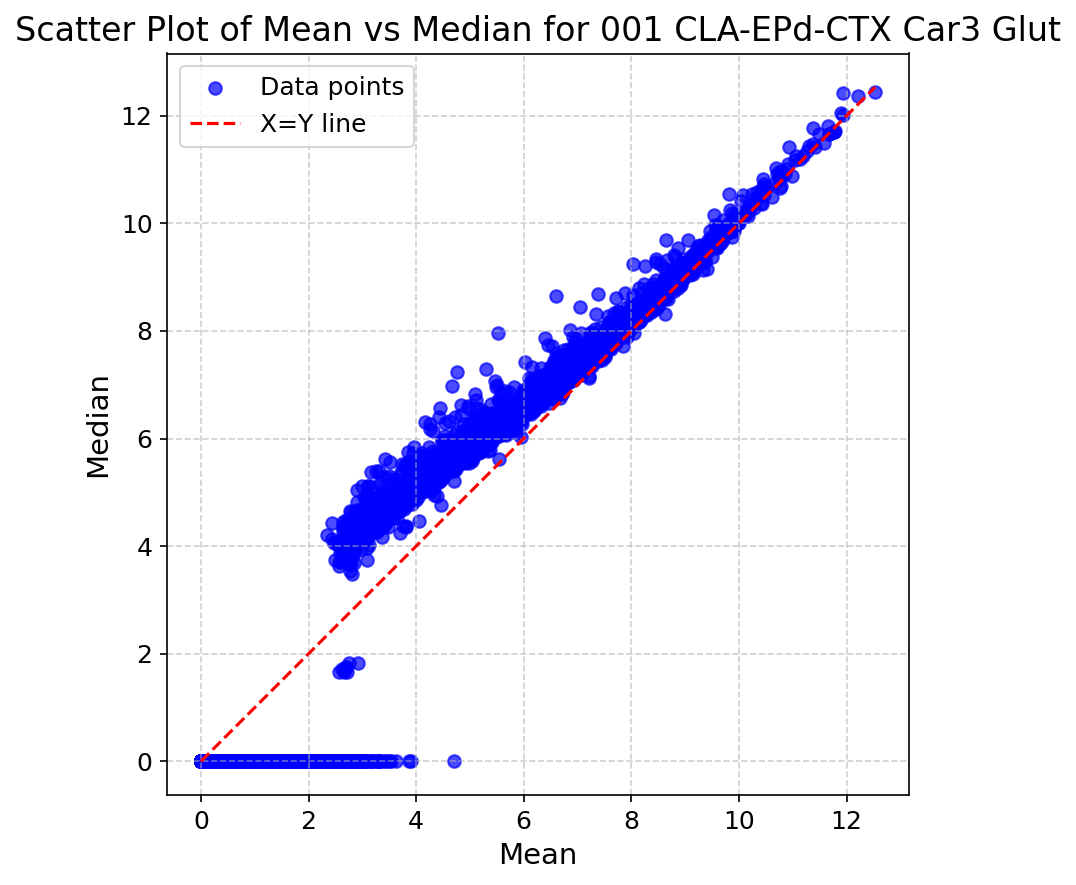

In [173]:
CT1 = "001 CLA-EPd-CTX Car3 Glut"
X = MeanDF[CT1].values
Y = MedianDF[CT1].values

plt.figure(dpi=150, figsize=(8, 6))

# Scatter plot
plt.scatter(X, Y, color='blue', alpha=0.7, label='Data points')

# Adding the X=Y line
min_val = min(min(X), min(Y))
max_val = max(max(X), max(Y))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='X=Y line')

# Labels and title
plt.xlabel('Mean', fontsize=14)
plt.ylabel('Median', fontsize=14)
plt.title(f'Scatter Plot of Mean vs Median for {CT}', fontsize=16)

# Adding a legend
plt.legend(fontsize=12)

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Adjusting tick parameters for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Setting equal aspect ratio for x and y axis
plt.gca().set_aspect('equal', adjustable='box')

# Showing the plot
plt.tight_layout()
plt.show()

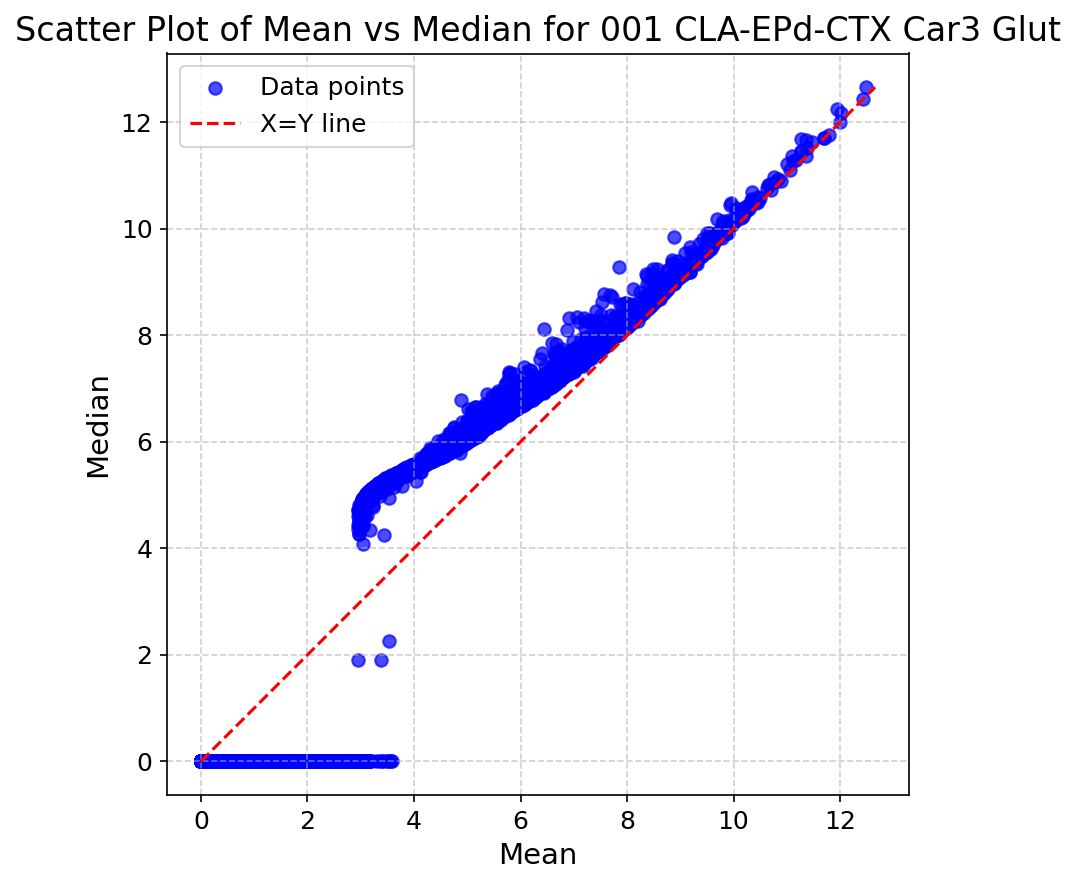

In [178]:
CT2 = "123 DMH Nkx2-4 Glut"
X = MeanDF[CT2].values
Y = MedianDF[CT2].values

plt.figure(dpi=150, figsize=(8, 6))

# Scatter plot
plt.scatter(X, Y, color='blue', alpha=0.7, label='Data points')

# Adding the X=Y line
min_val = min(min(X), min(Y))
max_val = max(max(X), max(Y))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='X=Y line')

# Labels and title
plt.xlabel('Mean', fontsize=14)
plt.ylabel('Median', fontsize=14)
plt.title(f'Scatter Plot of Mean vs Median for {CT}', fontsize=16)

# Adding a legend
plt.legend(fontsize=12)

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Adjusting tick parameters for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Setting equal aspect ratio for x and y axis
plt.gca().set_aspect('equal', adjustable='box')

# Showing the plot
plt.tight_layout()
plt.show()

In [179]:
print(CT1)
print(CT2)

001 CLA-EPd-CTX Car3 Glut
123 DMH Nkx2-4 Glut


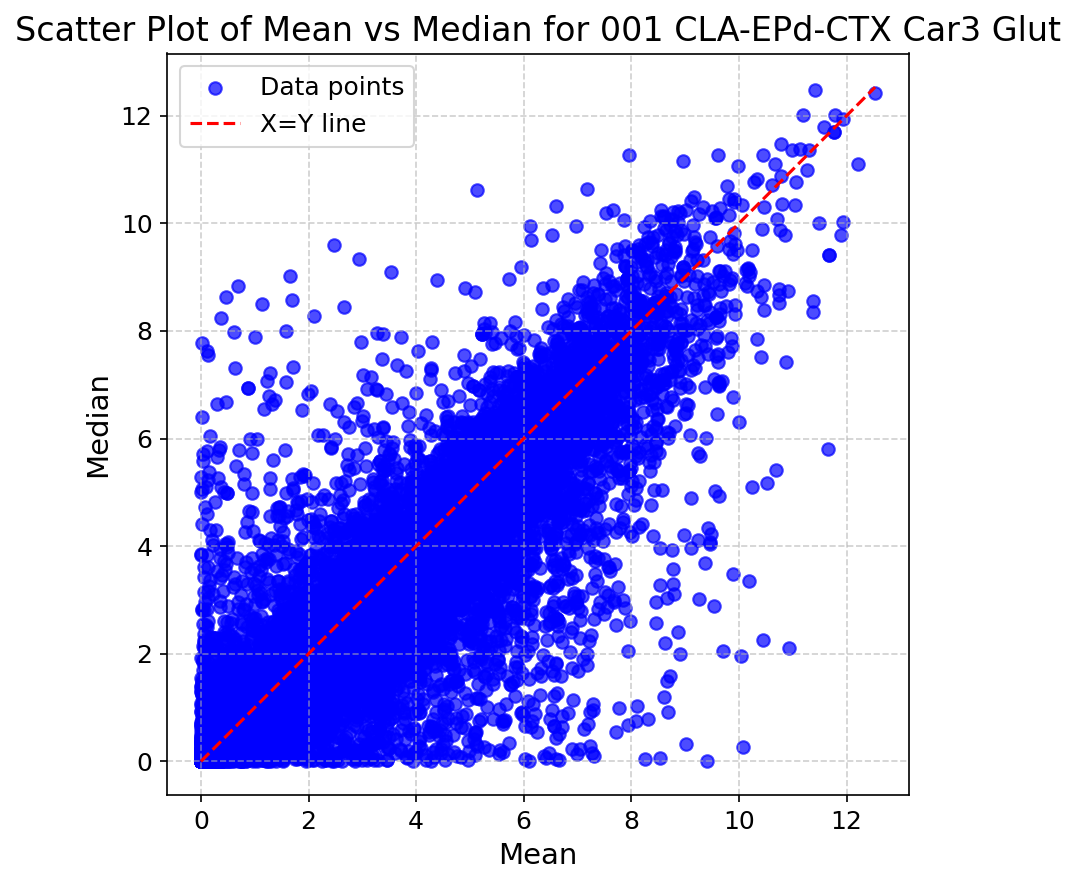

In [180]:
X = MeanDF[CT1].values
Y = MeanDF[CT2].values

plt.figure(dpi=150, figsize=(8, 6))

# Scatter plot
plt.scatter(X, Y, color='blue', alpha=0.7, label='Data points')

# Adding the X=Y line
min_val = min(min(X), min(Y))
max_val = max(max(X), max(Y))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='X=Y line')

# Labels and title
plt.xlabel('Mean', fontsize=14)
plt.ylabel('Median', fontsize=14)
plt.title(f'Scatter Plot of Mean vs Median for {CT}', fontsize=16)

# Adding a legend
plt.legend(fontsize=12)

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Adjusting tick parameters for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Setting equal aspect ratio for x and y axis
plt.gca().set_aspect('equal', adjustable='box')

# Showing the plot
plt.tight_layout()
plt.show()

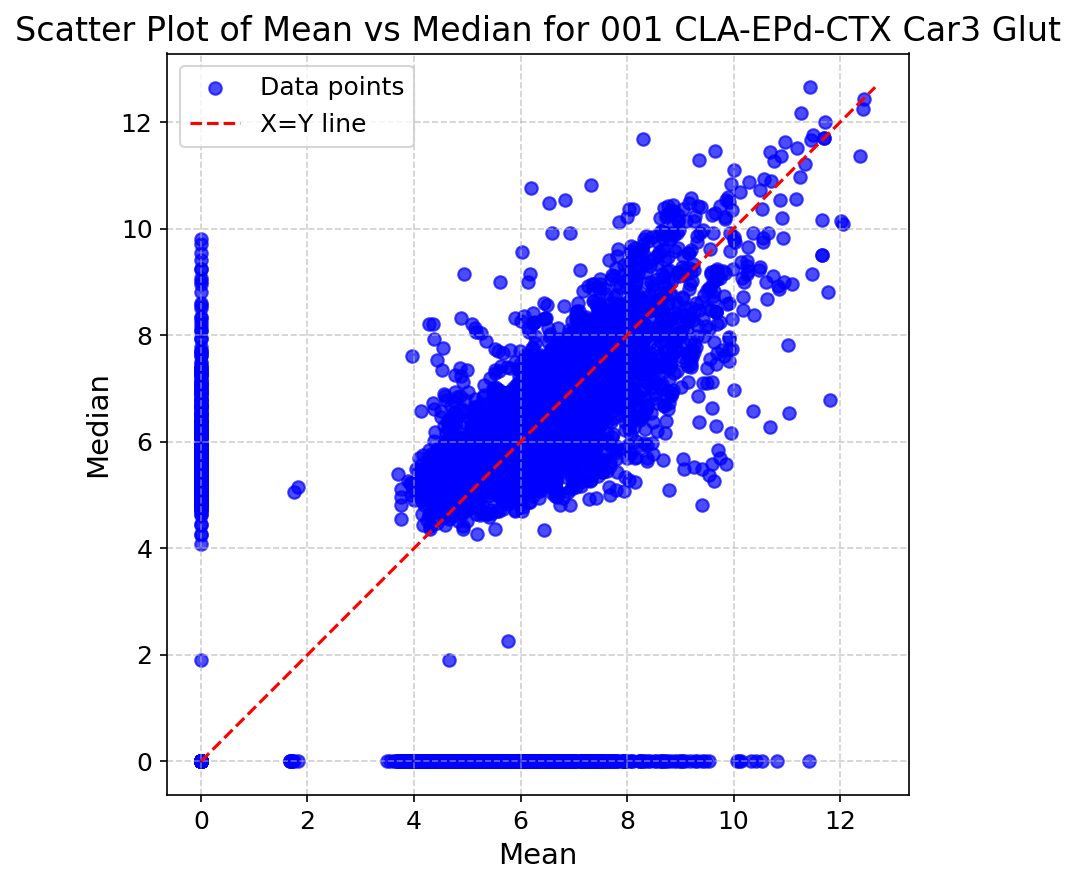

In [181]:
X = MedianDF[CT1].values
Y = MedianDF[CT2].values

plt.figure(dpi=150, figsize=(8, 6))

# Scatter plot
plt.scatter(X, Y, color='blue', alpha=0.7, label='Data points')

# Adding the X=Y line
min_val = min(min(X), min(Y))
max_val = max(max(X), max(Y))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='X=Y line')

# Labels and title
plt.xlabel('Mean', fontsize=14)
plt.ylabel('Median', fontsize=14)
plt.title(f'Scatter Plot of Mean vs Median for {CT}', fontsize=16)

# Adding a legend
plt.legend(fontsize=12)

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Adjusting tick parameters for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Setting equal aspect ratio for x and y axis
plt.gca().set_aspect('equal', adjustable='box')

# Showing the plot
plt.tight_layout()
plt.show()

In [196]:
Cluster_V3_ExpMat2 = pd.read_csv("dat/ExpressionMats_Median/test.cluster_V3_ExpMat.csv", index_col=0)

In [197]:
Cluster_V3_ExpMat2_HumanGene = ExpMatConvertEntrez(Cluster_V3_ExpMat2, ENSMUSG2HumanEntrez)
Cluster_V3_ExpMat2_HumanGene.to_csv("dat/ExpressionMats_Median/Cluster_V3_ExpMat.csv")

In [198]:
Cluster_V3_ExpMat2_HumanGene.head(2)

,0001 CLA-EPd-CTX Car3 Glut_1,0002 CLA-EPd-CTX Car3 Glut_1,0003 CLA-EPd-CTX Car3 Glut_1,0004 CLA-EPd-CTX Car3 Glut_1,0005 CLA-EPd-CTX Car3 Glut_2,0006 IT EP-CLA Glut_1,0007 IT EP-CLA Glut_1,0008 IT EP-CLA Glut_1,0009 IT EP-CLA Glut_1,0010 IT EP-CLA Glut_1,...,5313 BAM NN_1,5314 BAM NN_1,5315 Monocytes NN_1,5316 DC NN_1,5317 DC NN_1,5318 DC NN_1,5319 B cells NN_1,5320 ILC NN_2,5321 NK cells NN_3,5322 T cells NN_4
114786,8.596779,9.100198,8.863268,8.35424,8.057294,9.935088,10.114022,8.951933,9.361299,8.960622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6101,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
SuperType_V3_ExpMat2 = pd.read_csv("dat/ExpressionMats_Median/test.supertype_V3_ExpMat.csv", index_col=0)
SuperType_V3_ExpMat2_HumanGene = ExpMatConvertEntrez(SuperType_V3_ExpMat2, ENSMUSG2HumanEntrez)
SuperType_V3_ExpMat2_HumanGene.to_csv("dat/ExpressionMats_Median/Supertype_V3_ExpMat.csv")

In [203]:
STR_MERFISH_MarkerG = pd.read_csv("dat/MERFISH_MarkerG/test.csv", index_col=0)
STR_MERFISH_MarkerG_HumanGene = ExpMatConvertEntrez(STR_MERFISH_MarkerG, ENSMUSG2HumanEntrez)
STR_MERFISH_MarkerG_HumanGene.to_csv("dat/MERFISH_MarkerG/STR_MERFISH_MarkerG.csv")

#### [end] Compare Mean and Median

###### Old

In [27]:
Split_Exp_Dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/AggregatedExpMat/"

In [28]:
#label = "subclass"
label = "cluster"
Splited_Mats = {}
NumCells = {}
for feature in feature_matrix_label:
    SubExpMat = pd.read_csv("{}/ExpMat.{}.{}.csv".format(Split_Exp_Dir, feature, label), index_col=0)
    CellNum = LoadDict("{}/NumCells.{}.{}.csv".format(Split_Exp_Dir, feature, label))
    Splited_Mats[feature] = SubExpMat
    NumCells[feature] = CellNum

In [29]:
CellTypes = cell_extended[label].unique()
CellTypes.sort()

In [30]:
Genes = Splited_Mats[feature_matrix_label[0]].index.values

In [31]:
CombineMat = pd.DataFrame(data=np.zeros((len(Genes), len(CellTypes))), index=Genes, columns=CellTypes)

In [32]:
CombineMat

,0001 CLA-EPd-CTX Car3 Glut_1,0002 CLA-EPd-CTX Car3 Glut_1,0003 CLA-EPd-CTX Car3 Glut_1,0004 CLA-EPd-CTX Car3 Glut_1,0005 CLA-EPd-CTX Car3 Glut_2,0006 IT EP-CLA Glut_1,0007 IT EP-CLA Glut_1,0008 IT EP-CLA Glut_1,0009 IT EP-CLA Glut_1,0010 IT EP-CLA Glut_1,...,5313 BAM NN_1,5314 BAM NN_1,5315 Monocytes NN_1,5316 DC NN_1,5317 DC NN_1,5318 DC NN_1,5319 B cells NN_1,5320 ILC NN_2,5321 NK cells NN_3,5322 T cells NN_4
ENSMUSG00000051951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000089699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000102331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000102343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000025900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000095523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000095475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000094855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000095019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
TotalCellNum = np.zeros(len(CellTypes))
for feature in feature_matrix_label:
    SubExpMat = Splited_Mats[feature]
    CellNum = NumCells[feature] 
    for i, CT in enumerate(CellTypes):
        if CT not in CellNum:
            addCol = np.zeros(len(Genes))
        else:
            addCol = SubExpMat[CT].values * CellNum[CT]
            TotalCellNum[i] = TotalCellNum[i] + CellNum[CT]
        CombineMat[CT] = CombineMat[CT] + addCol

In [35]:
for i, CT in enumerate(CellTypes):
    CombineMat[CT] = CombineMat[CT]/TotalCellNum[i]

In [36]:
CombineMat

,0001 CLA-EPd-CTX Car3 Glut_1,0002 CLA-EPd-CTX Car3 Glut_1,0003 CLA-EPd-CTX Car3 Glut_1,0004 CLA-EPd-CTX Car3 Glut_1,0005 CLA-EPd-CTX Car3 Glut_2,0006 IT EP-CLA Glut_1,0007 IT EP-CLA Glut_1,0008 IT EP-CLA Glut_1,0009 IT EP-CLA Glut_1,0010 IT EP-CLA Glut_1,...,5313 BAM NN_1,5314 BAM NN_1,5315 Monocytes NN_1,5316 DC NN_1,5317 DC NN_1,5318 DC NN_1,5319 B cells NN_1,5320 ILC NN_2,5321 NK cells NN_3,5322 T cells NN_4
ENSMUSG00000051951,7.507714,7.719183,7.691484,7.291934,6.683277,9.319730,9.618341,8.127503,8.919748,8.054258,...,0.958966,0.930223,1.329243,1.228138,1.201019,0.843265,1.028256,1.879817,0.767556,1.229226
ENSMUSG00000089699,0.819192,0.823025,0.890653,0.768149,0.544352,1.691094,2.247481,0.993797,1.385413,1.010116,...,0.063581,0.068075,0.000000,0.329901,0.136605,0.073437,0.233036,0.000000,0.080485,0.120368
ENSMUSG00000102331,2.898855,2.978951,2.756666,2.458693,2.210328,4.652402,5.081863,3.125429,4.494057,3.447801,...,0.145952,0.158200,0.000000,0.143375,0.141483,0.038375,0.242053,0.000000,0.130718,0.208769
ENSMUSG00000102343,0.001923,0.002870,0.006263,0.005459,0.008301,0.003449,0.005130,0.001584,0.006506,0.011820,...,0.000000,0.002467,0.000000,0.000000,0.000000,0.030773,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000025900,0.016889,0.014209,0.015740,0.013444,0.018012,0.045909,0.055358,0.018987,0.032062,0.031806,...,0.012016,0.016556,0.000000,0.120560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000095523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000095475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000094855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000095019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### convert index to humen entrez ID

###### mouse ENSMUSG ID to symbol

In [89]:
def parse_gtf(file_path):
    features = []
    GeneID2GeneSymbol = {}
    Failed_Mapping = []
    with gz.open(file_path, 'rt') as gtf_file:
        for line in gtf_file:
            if line.startswith('#'):
                continue  # Skip comment lines
            fields = line.strip().split('\t')
            # GTF fields: seqname, source, feature, start, end, score, strand, frame, attributes
            seqname, source, feature, start, end, score, strand, frame, attributes = fields
            # Only consider gene feature
            if feature != "gene":
                continue
            # Parse attributes into a dictionary
            attribute_dict = {}
            for attribute in attributes.split('; '):
                #print(attribute)
                key, value = attribute.strip().split(' ')
                attribute_dict[key] = value.strip('"').strip('";"')
            # Get gene_id to symnol map
            if attribute_dict["gene_biotype"] != "protein_coding":
                #print(attribute_dict["gene_biotype"])
                continue
            try:
                GeneID2GeneSymbol[attribute_dict["gene_id"]] = attribute_dict["gene_name"]
            except:
                Failed_Mapping.append(attribute_dict)
    return GeneID2GeneSymbol

In [90]:
gtf_file_path = '/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/Mus_musculus.GRCm39.110.gtf.gz'
Mouse_GeneID2GeneSymbol = parse_gtf(gtf_file_path)

In [91]:
print(len(Mouse_GeneID2GeneSymbol))

21606


###### Human 2 mouse gene mapping

In [93]:
Human2MouseHom = pd.read_csv("../../ASD_Circuits/scripts//HOM_MouseHumanSequence.rpt", delimiter="\t")

In [94]:
Homo_IDs = set(Human2MouseHom["DB Class Key"].values)
print(len(Homo_IDs))

20602


In [95]:
MouseSymbol2HumanEntrez = {}
Human2Mouse_Genes = {}
Mouse2Human_Genes = {}
for counter, ID in enumerate(Homo_IDs):
    tmp_df = Human2MouseHom[Human2MouseHom["DB Class Key"]==ID]

    hum_genes, mou_genes = [], []
    for i, row in tmp_df.iterrows():
        TaxonID = row["NCBI Taxon ID"]
        Symbol = row["Symbol"]
        Entrez = row["EntrezGene ID"]
        if  TaxonID == 9606:
            hum_genes.append((Symbol, Entrez))
        elif TaxonID == 10090:
            mou_genes.append((Symbol, Entrez))
    # Fill up Human2Mouse_Genes
    for (Symbol, Entrez) in hum_genes:
        if Entrez not in Human2Mouse_Genes:
            Human2Mouse_Genes[Entrez] = {}#mou_genes
            Human2Mouse_Genes[Entrez]["symbol"] = Symbol
            Human2Mouse_Genes[Entrez]["mouseHomo"] = mou_genes
        else:
            Human2Mouse_Genes[Entrez]["mouseHomo"].extend(mou_genes)
        
    # Fill up Mouse2Human_Genes
    for (Symbol, Entrez) in mou_genes:
        if Entrez not in Mouse2Human_Genes:
            Mouse2Human_Genes[Symbol] = {} #mou_genes
            Mouse2Human_Genes[Symbol]["entrez"] = Entrez
            Mouse2Human_Genes[Symbol]["humanHomo"] = hum_genes
        else:
            Mouse2Human_Genes[Symbol]["humanHomo"].extend(hum_genes)

In [96]:
Mouse2Human_Genes

{'Gdnf': {'entrez': 14573, 'humanHomo': [('GDNF', 2668)]},
 'Star': {'entrez': 20845, 'humanHomo': [('STAR', 6770)]},
 'Fzd2': {'entrez': 57265, 'humanHomo': [('FZD2', 2535)]},
 'Hoxa11': {'entrez': 15396, 'humanHomo': [('HOXA11', 3207)]},
 'Hoxc11': {'entrez': 109663, 'humanHomo': [('HOXC11', 3227)]},
 'Sptbn5': {'entrez': 640524, 'humanHomo': [('SPTBN5', 51332)]},
 'Zfp365': {'entrez': 216049, 'humanHomo': [('ZNF365', 22891)]},
 'Wdr53': {'entrez': 68980, 'humanHomo': [('WDR53', 348793)]},
 'Tdg-ps2': {'entrez': 624784, 'humanHomo': [('TDG', 6996)]},
 'Tdg': {'entrez': 21665, 'humanHomo': [('TDG', 6996)]},
 'Trarg1': {'entrez': 237858, 'humanHomo': [('TRARG1', 286753)]},
 'Pdgfb': {'entrez': 18591, 'humanHomo': [('PDGFB', 5155)]},
 'Gpr171': {'entrez': 229323, 'humanHomo': [('GPR171', 29909)]},
 'Glyatl3': {'entrez': 435528, 'humanHomo': [('GLYATL3', 389396)]},
 'Keg1': {'entrez': 64697, 'humanHomo': [('GLYAT', 10249)]},
 'Gm4952': {'entrez': 240549, 'humanHomo': []},
 'Glyat': {'ent

In [110]:
with open("Mouse2HumanGenes", 'w') as json_file:
    json.dump(Mouse2Human_Genes, json_file)

##### Check mapping from ABC atlas to Human Entrez 

In [158]:
def ExpMatConvertEntrez(CombineMat, ENSMUSG2HumanEntrez):
    dat_rows = []
    index = []
    for ensg, row in CombineMat.iterrows():
        if ensg in ENSMUSG2HumanEntrez:
            for entrez in ENSMUSG2HumanEntrez[ensg]:
                index.append(entrez)
                dat_rows.append(row)
    ExpDF_humanEntrez = pd.DataFrame(data=dat_rows, index=index, columns=CombineMat.columns.values)
    ExpDF_humanEntrezDedup = ExpDF_humanEntrez[~ExpDF_humanEntrez.index.duplicated(keep='first')]
    return ExpDF_humanEntrezDedup

In [101]:
Subclass_V2_ExpMat = ExpMatConvertEntrez(CombineMat_v2, ENSMUSG2HumanEntrez)
Subclass_V3_ExpMat = ExpMatConvertEntrez(CombineMat_v3, ENSMUSG2HumanEntrez)

In [102]:
Subclass_V2_ExpMat.to_csv("dat/ExpressionMats/{}_V2_ExpMat.csv".format(label))
Subclass_V3_ExpMat.to_csv("dat/ExpressionMats/{}_V3_ExpMat.csv".format(label))

In [186]:
#ENSMUSG2HumanEntrez.to
with open("Mouse2HumanGenes", 'w') as json_file:
    json.dump(Mouse2Human_Genes, json_file)

{'ENSMUSG00000051951': [114786],
 'ENSMUSG00000025900': [6101],
 'ENSMUSG00000025902': [64321],
 'ENSMUSG00000033845': [29088],
 'ENSMUSG00000025903': [10434],
 'ENSMUSG00000033813': [6917],
 'ENSMUSG00000002459': [8601],
 'ENSMUSG00000033793': [51606],
 'ENSMUSG00000025905': [4986],
 'ENSMUSG00000033774': [2831],
 'ENSMUSG00000025907': [9821],
 'ENSMUSG00000087247': [389658],
 'ENSMUSG00000033740': [9705],
 'ENSMUSG00000051285': [115294],
 'ENSMUSG00000025909': [54212],
 'ENSMUSG00000061024': [23212],
 'ENSMUSG00000025911': [137872],
 'ENSMUSG00000067879': [254778],
 'ENSMUSG00000025912': [4603],
 'ENSMUSG00000045210': [80124],
 'ENSMUSG00000025915': [100533105, 23678],
 'ENSMUSG00000046101': [157777],
 'ENSMUSG00000099032': [100129654],
 'ENSMUSG00000025916': [286187],
 'ENSMUSG00000025917': [10987],
 'ENSMUSG00000056763': [79848],
 'ENSMUSG00000067851': [10565],
 'ENSMUSG00000042501': [57094],
 'ENSMUSG00000048960': [80243],
 'ENSMUSG00000057715': [116328],
 'ENSMUSG00000016918': [2

In [223]:
ENSMUSG2HumanEntrez
with open("dat/ENSMUSG2HumanEntrez.json", 'w') as json_file:
    json.dump(ENSMUSG2HumanEntrez, json_file)

###### Old

In [99]:
ENSMUSG_no_symbol_or_not_protein_coding = []
Mouse2Human_noMap = []
Mouse2Human_uniqMap = []
Mouse2Human_multiMap = []
ENSMUSG2HumanEntrez = {}
for msg in Genes:
    if msg in Mouse_GeneID2GeneSymbol:
        mouse_symbol = Mouse_GeneID2GeneSymbol[msg]
        if mouse_symbol not in Mouse2Human_Genes:
            Mouse2Human_noMap.append(msg)
            continue
        human_entrez = Mouse2Human_Genes[mouse_symbol]["humanHomo"]
        if len(human_entrez) == 0:
            Mouse2Human_noMap.append(msg)
        if len(human_entrez) == 1:
            Mouse2Human_uniqMap.append(msg)
            ENSMUSG2HumanEntrez[msg] = [x[1] for x in human_entrez]
        else:
            Mouse2Human_multiMap.append(msg)
            ENSMUSG2HumanEntrez[msg] = [x[1] for x in human_entrez]
    else:
        ENSMUSG_no_symbol_or_not_protein_coding.append(msg)

In [222]:
len(ENSMUSG2HumanEntrez)

18795

In [221]:
print(len(ENSMUSG_no_symbol_or_not_protein_coding))
print(len(Mouse2Human_noMap))
print(len(Mouse2Human_uniqMap))
print(len(Mouse2Human_multiMap))

11012
3121
17193
1602


In [47]:
def AvgDupes(df):
    duplicate_index = df[df.index.duplicated(keep=False)]

    # Iterate through duplicate index values and average their data
    for index_value in duplicate_index.index.unique():
        duplicate_rows = df.loc[df.index == index_value]
        average_values = duplicate_rows.mean(axis=0)
    # Drop the duplicated index values
    df = df[~df.index.duplicated(keep='first')]
    df.loc[index_value, :] = average_values
    return df

In [48]:
dat_rows = []
index = []
for ensg, row in CombineMat.iterrows():
    if ensg in ENSMUSG2HumanEntrez:
        for entrez in ENSMUSG2HumanEntrez[ensg]:
            index.append(entrez)
            dat_rows.append(row)
ExpDF_humanEntrez = pd.DataFrame(data=dat_rows, index=index, columns=CombineMat.columns.values)

In [49]:
#ExpDF_humanEntrezDedup = AvgDupes(ExpDF_humanEntrez)
ExpDF_humanEntrezDedup = ExpDF_humanEntrez[~ExpDF_humanEntrez.index.duplicated(keep='first')]
ExpDF_humanEntrezDedup.to_csv("dat/ExpMat.{}.HumanEntrez.csv".format(label))

In [50]:
ExpDF_humanEntrezDedup

,0001 CLA-EPd-CTX Car3 Glut_1,0002 CLA-EPd-CTX Car3 Glut_1,0003 CLA-EPd-CTX Car3 Glut_1,0004 CLA-EPd-CTX Car3 Glut_1,0005 CLA-EPd-CTX Car3 Glut_2,0006 IT EP-CLA Glut_1,0007 IT EP-CLA Glut_1,0008 IT EP-CLA Glut_1,0009 IT EP-CLA Glut_1,0010 IT EP-CLA Glut_1,...,5313 BAM NN_1,5314 BAM NN_1,5315 Monocytes NN_1,5316 DC NN_1,5317 DC NN_1,5318 DC NN_1,5319 B cells NN_1,5320 ILC NN_2,5321 NK cells NN_3,5322 T cells NN_4
114786,7.507714,7.719183,7.691484,7.291934,6.683277,9.319730,9.618341,8.127503,8.919748,8.054258,...,0.958966,0.930223,1.329243,1.228138,1.201019,0.843265,1.028256,1.879817,0.767556,1.229226
6101,0.016889,0.014209,0.015740,0.013444,0.018012,0.045909,0.055358,0.018987,0.032062,0.031806,...,0.012016,0.016556,0.000000,0.120560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
64321,0.004333,0.007246,0.006411,0.007263,0.000000,0.011151,0.011654,0.006440,0.010352,0.008024,...,0.055657,0.039081,0.000000,0.000000,0.150127,0.033448,0.000000,0.000000,0.102043,0.104039
29088,1.822539,1.711366,1.485974,1.616358,1.459034,1.640799,2.040097,1.594824,1.838773,1.457045,...,1.176766,1.212862,0.850636,3.360942,2.232367,1.742458,0.890041,2.106739,1.840492,1.054258
10434,2.609254,2.596179,2.193242,2.299031,1.738549,2.303846,2.561084,1.925965,2.597904,2.530876,...,2.003080,1.809956,1.145602,3.191985,2.094378,2.688681,1.959012,2.056330,1.984539,1.674894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4539,6.259445,6.175625,5.534608,5.497456,5.703128,6.247576,7.008011,6.441457,6.582167,5.929932,...,6.208517,6.359146,4.998079,4.556680,6.363575,5.129371,6.875309,7.052457,5.645396,5.449984
4538,11.114177,11.174157,10.863713,10.810493,10.993093,11.154454,11.311575,11.155735,11.300961,11.099405,...,11.277194,11.263921,10.304599,9.220864,10.879012,10.315419,11.568090,11.554875,11.072365,10.881783
4540,7.767483,7.687196,7.225159,7.136053,7.380529,7.812790,8.353352,7.952138,8.209451,7.756236,...,7.469666,7.776754,6.147838,6.598449,7.483865,7.290616,8.335016,8.482276,7.762983,7.298620
4541,1.630039,1.531436,1.341870,1.313154,0.995038,2.396126,3.041241,2.315495,2.025845,1.640263,...,3.330895,3.476982,2.368453,3.149455,2.552996,2.398420,1.931960,3.591816,2.067256,2.275060


In [51]:
print(len(Mouse2Human_uniqMap))
print(len(ENSMUSG2HumanEntrez))

17193
18795


#### Cal Z1 Mat

In [6]:
def Z1Conversion(ExpMat, outname="test.z1.mat"):
    Z_mat = []
    for g, row in ExpMat.iterrows():
        tmp = ZscoreConverting(row.values)
        Z_mat.append(tmp)
    Z_mat = np.array(Z_mat)
    CT_Z1_DF = pd.DataFrame(data=Z_mat, index=ExpMat.index.values, 
                            columns=ExpMat.columns.values)
    CT_Z1_DF.to_csv(outname)
    return CT_Z1_DF

In [184]:
MedianDF = pd.read_csv("dat/ExpressionMats_Median/subclass_V3_ExpMat.csv", index_col=0)
MedianDF_Z1 = Z1Conversion(MedianDF, "dat/ExpressionMats_Median/Subclass_V3_Z1Mat.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [5]:
Z1Conversion(Subclass_V2_ExpMat, "dat/ExpressionMats/Subclass_V2_Z1Mat.csv")
Z1Conversion(Subclass_V3_ExpMat, "dat/ExpressionMats/Subclass_V3_Z1Mat.csv")

NameError: name 'Subclass_V2_ExpMat' is not defined

In [8]:
Cluster_CB_ExpMat = pd.read_csv("dat/ExpressionMats/Cluster_CB_ExpMat.csv", index_col=0)
Z1Conversion(Cluster_CB_ExpMat, "dat/ExpressionMats/Cluster_CB_Z1Mat.csv")

In [7]:
Cluster_CB_ExpMat

,Unnamed: 0,0001 CLA-EPd-CTX Car3 Glut_1,0002 CLA-EPd-CTX Car3 Glut_1,0003 CLA-EPd-CTX Car3 Glut_1,0004 CLA-EPd-CTX Car3 Glut_1,0005 CLA-EPd-CTX Car3 Glut_2,0006 IT EP-CLA Glut_1,0007 IT EP-CLA Glut_1,0008 IT EP-CLA Glut_1,0009 IT EP-CLA Glut_1,...,5313 BAM NN_1,5314 BAM NN_1,5315 Monocytes NN_1,5316 DC NN_1,5317 DC NN_1,5318 DC NN_1,5319 B cells NN_1,5320 ILC NN_2,5321 NK cells NN_3,5322 T cells NN_4
0,114786,7.521852,7.734528,7.703336,7.305105,7.021075,9.348117,9.628793,8.157314,8.927051,...,0.960404,0.965489,1.471845,1.300674,1.269402,0.938667,1.118987,1.889799,0.776854,1.437679
1,6101,0.338342,0.349668,0.348767,0.344401,0.366447,0.322765,0.245205,0.258155,0.307348,...,0.014641,0.027599,0.042017,0.169362,0.018994,0.030474,0.030813,0.012380,0.010504,0.059225
2,64321,0.315983,0.336118,0.330780,0.333391,0.332855,0.266150,0.184941,0.234641,0.274398,...,0.058413,0.051895,0.042017,0.046219,0.170355,0.064571,0.030813,0.012380,0.112387,0.167421
3,29088,3.026955,2.945450,2.643510,2.810551,2.646172,2.564215,2.699798,2.411808,2.821254,...,1.184918,1.246873,0.981151,3.479181,2.310253,1.848569,0.931841,2.114777,1.848105,1.207436
4,10434,3.935021,3.985275,3.527595,3.647046,3.019613,3.364061,3.276224,2.822997,3.711344,...,2.013420,1.847902,1.288243,3.306604,2.130586,2.820617,2.081371,2.066088,1.991925,1.845515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17933,4539,6.849708,6.773955,6.382127,6.363980,6.475567,6.897343,7.412476,7.053724,7.109527,...,6.228989,6.418936,5.243377,4.782748,6.457758,5.312291,6.895466,7.055842,5.684532,5.825967
17934,4538,11.116192,11.175352,10.863519,10.812063,10.991856,11.160261,11.312542,11.160714,11.304632,...,11.278017,11.266267,10.302754,9.267236,10.877047,10.329267,11.564622,11.554683,11.067593,10.924804
17935,4540,7.786228,7.700189,7.240051,7.154407,7.388079,7.856399,8.370973,7.993364,8.227960,...,7.484446,7.809447,6.152746,6.862266,7.594307,7.347851,8.514833,8.483837,7.761290,7.621098
17936,4541,2.751864,2.689048,2.426612,2.384735,1.968653,3.454264,3.677493,3.193982,2.908852,...,3.345247,3.511798,2.470280,3.263162,2.592974,2.517998,1.986624,3.599615,2.074512,2.461405


In [52]:
Z_mat = []
for g, row in ExpDF_humanEntrezDedup.iterrows():
    tmp = ZscoreConverting(row.values)
    Z_mat.append(tmp)
Z_mat = np.array(Z_mat)
CT_Z1_DF = pd.DataFrame(data=Z_mat, index=ExpDF_humanEntrezDedup.index.values, 
                        columns=ExpDF_humanEntrezDedup.columns.values)
CT_Z1_DF.to_csv("dat/Z1Mat.{}.HumanEntrez.csv".format(label))

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [107]:
FusionExpMat = pd.read_csv("dat/ExpressionMats/Fusion_Exp.csv", index_col=0)
Z1Conversion(FusionExpMat, "dat/ExpressionMats/Fusion_Z1Mat.csv")

In [200]:
FusionExpMat = pd.read_csv("dat/ExpressionMats_Median/Fusion_Exp.csv", index_col=0)
FusionZ1 = Z1Conversion(FusionExpMat, "dat/ExpressionMats_Median//Fusion_Z1Mat.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [215]:
ExpMat = pd.read_csv("dat/MERFISH_Zhuang/STR_Cell_Mean_DF.csv", index_col=0)
Z1Mat = Z1Conversion(ExpMat, "dat/MERFISH_Zhuang/STR_Cell_Mean_DF.Z1.csv")
ExpMat = pd.read_csv("dat/MERFISH_Zhuang/STR_Vol_Mean_DF.csv", index_col=0)
Z1Mat = Z1Conversion(ExpMat, "dat/MERFISH_Zhuang/STR_Vol_Mean_DF.Z1.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std
/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


##### Cal Exp Matching features

In [114]:
g_exp_v2 = []
for i, g in enumerate(Subclass_V2_ExpMat.index.values):
    res = 0
    for j, c in enumerate(Subclass_V2_ExpMat.columns.values):
        exp_l = Subclass_V2_ExpMat.loc[g, c]
        if exp_l == exp_l:
            res += exp_l * TotalCellNum_v2[j]
        else:
            res += 0
    g_exp_v2.append(res)
    if i % 100 ==0:
        print("processed",i,"genes") 

processed 0 genes
processed 100 genes
processed 200 genes
processed 300 genes
processed 400 genes
processed 500 genes
processed 600 genes
processed 700 genes
processed 800 genes
processed 900 genes
processed 1000 genes
processed 1100 genes
processed 1200 genes
processed 1300 genes
processed 1400 genes
processed 1500 genes
processed 1600 genes
processed 1700 genes
processed 1800 genes
processed 1900 genes
processed 2000 genes
processed 2100 genes
processed 2200 genes
processed 2300 genes
processed 2400 genes
processed 2500 genes
processed 2600 genes
processed 2700 genes
processed 2800 genes
processed 2900 genes
processed 3000 genes
processed 3100 genes
processed 3200 genes
processed 3300 genes
processed 3400 genes
processed 3500 genes
processed 3600 genes
processed 3700 genes
processed 3800 genes
processed 3900 genes
processed 4000 genes
processed 4100 genes
processed 4200 genes
processed 4300 genes
processed 4400 genes
processed 4500 genes
processed 4600 genes
processed 4700 genes
proc

In [115]:
V2_Exp_DF = pd.DataFrame(data={"Gene":Subclass_V2_ExpMat.index.values, "Exp":g_exp_v2})
V2_Exp_DF = V2_Exp_DF.sort_values("Exp")
V2_Exp_DF["Rank"] = [1+x for x in range(V2_Exp_DF.shape[0])] # compute Rank
V2_Exp_DF["quantile"] = V2_Exp_DF["Rank"]/V2_Exp_DF.shape[0]
V2_Exp_DF = V2_Exp_DF.set_index("Gene")
V2_Exp_DF.to_csv("dat/ABC_TotalExp.Match.10xV2.csv")

In [116]:
g_exp_v3 = []
for i, g in enumerate(Subclass_V3_ExpMat.index.values):
    res = 0
    for j, c in enumerate(Subclass_V3_ExpMat.columns.values):
        exp_l = Subclass_V2_ExpMat.loc[g, c]
        if exp_l == exp_l:
            res += exp_l * TotalCellNum_v3[j]
        else:
            res += 0
    g_exp_v3.append(res)
    if i % 100 ==0:
        print("processed",i,"genes") 

processed 0 genes
processed 100 genes
processed 200 genes
processed 300 genes
processed 400 genes
processed 500 genes
processed 600 genes
processed 700 genes
processed 800 genes
processed 900 genes
processed 1000 genes
processed 1100 genes
processed 1200 genes
processed 1300 genes
processed 1400 genes
processed 1500 genes
processed 1600 genes
processed 1700 genes
processed 1800 genes
processed 1900 genes
processed 2000 genes
processed 2100 genes
processed 2200 genes
processed 2300 genes
processed 2400 genes
processed 2500 genes
processed 2600 genes
processed 2700 genes
processed 2800 genes
processed 2900 genes
processed 3000 genes
processed 3100 genes
processed 3200 genes
processed 3300 genes
processed 3400 genes
processed 3500 genes
processed 3600 genes
processed 3700 genes
processed 3800 genes
processed 3900 genes
processed 4000 genes
processed 4100 genes
processed 4200 genes
processed 4300 genes
processed 4400 genes
processed 4500 genes
processed 4600 genes
processed 4700 genes
proc

In [117]:
V3_Exp_DF = pd.DataFrame(data={"Gene":Subclass_V3_ExpMat.index.values, "Exp":g_exp_v3})
V3_Exp_DF = V3_Exp_DF.sort_values("Exp")
V3_Exp_DF["Rank"] = [1+x for x in range(V3_Exp_DF.shape[0])] # compute Rank
V3_Exp_DF["quantile"] = V3_Exp_DF["Rank"]/V3_Exp_DF.shape[0]
V3_Exp_DF = V3_Exp_DF.set_index("Gene")
V3_Exp_DF.to_csv("dat/ABC_TotalExp.Match.10xV3.csv")

In [230]:
g_exp_wb = []
for i, g in enumerate(ExpDF_humanEntrezDedup.index.values):
    res = 0
    for j, c in enumerate(ExpDF_humanEntrezDedup.columns.values):
        exp_l = ExpDF_humanEntrezDedup.loc[g, c]
        if exp_l == exp_l:
            res += exp_l * TotalCellNum[j]
        else:
            res += 0
    g_exp_wb.append(res)
    if i % 100 ==0:
        print("processed",i,"genes") 

processed 0 genes
processed 100 genes
processed 200 genes
processed 300 genes
processed 400 genes
processed 500 genes
processed 600 genes
processed 700 genes
processed 800 genes
processed 900 genes
processed 1000 genes
processed 1100 genes
processed 1200 genes
processed 1300 genes
processed 1400 genes
processed 1500 genes
processed 1600 genes
processed 1700 genes
processed 1800 genes
processed 1900 genes
processed 2000 genes
processed 2100 genes
processed 2200 genes
processed 2300 genes
processed 2400 genes
processed 2500 genes
processed 2600 genes
processed 2700 genes
processed 2800 genes
processed 2900 genes
processed 3000 genes
processed 3100 genes
processed 3200 genes
processed 3300 genes
processed 3400 genes
processed 3500 genes
processed 3600 genes
processed 3700 genes
processed 3800 genes
processed 3900 genes
processed 4000 genes
processed 4100 genes
processed 4200 genes
processed 4300 genes
processed 4400 genes
processed 4500 genes
processed 4600 genes
processed 4700 genes
proc

In [228]:
g_exp_wb

[31309648.607059896,
 203012.88902353728,
 607808.2546358138,
 7390608.7992268065,
 9811114.497513302,
 20484857.482337784,
 14411083.756106973,
 18038954.954042573,
 2286379.1215923103,
 272398.3550767513,
 24099075.23549752,
 217875.5006133553,
 7307473.051921223,
 27342614.527999636,
 29672236.056069408,
 5287821.176779022,
 2332091.228144592,
 13957964.31993121,
 1246399.6099558424,
 15353085.315121321,
 8811983.68733708,
 8811983.68733708,
 3533848.1249056887,
 66216.25002907758,
 583731.9087147056,
 11421064.322268497,
 21259378.55412564,
 21925082.266516708,
 2557591.1046727328,
 8223658.912278372,
 19940112.78820607,
 5383060.375271676,
 1928317.7734477129,
 23500.14585752785,
 25722886.72328085,
 10096806.126941701,
 5151684.647814044,
 9963.222382308717,
 2986898.408472822,
 737406.6167345844,
 63234.13320455158,
 26278595.565735217,
 10457492.11408459,
 332602.4788583237,
 1770983.7971118453,
 33371593.761679623,
 4101566.2206763,
 25104981.91290312,
 23516019.11800762,
 235

In [231]:
Neuro_Exp_DF = pd.DataFrame(data={"Gene":ExpDF_humanEntrezDedup.index.values, "Exp":g_exp_wb})
Neuro_Exp_DF = Neuro_Exp_DF.sort_values("Exp")
Neuro_Exp_DF["Rank"] = [1+x for x in range(Neuro_Exp_DF.shape[0])] # compute Rank
Neuro_Exp_DF["quantile"] = Neuro_Exp_DF["Rank"]/Neuro_Exp_DF.shape[0]
Neuro_Exp_DF = Neuro_Exp_DF.drop_duplicates(subset="Gene", keep="first")
Neuro_Exp_DF = Neuro_Exp_DF.set_index("Gene")
Neuro_Exp_DF.to_csv("dat/ABC_TotalExp.Match.v2.csv")

In [232]:
Neuro_Exp_DF

,Exp,Rank,quantile
Gene,,,
163778,0.000000e+00,1,0.000056
337976,0.000000e+00,2,0.000111
259308,0.000000e+00,3,0.000167
337974,0.000000e+00,4,0.000223
6736,0.000000e+00,5,0.000279
...,...,...,...
4513,5.207192e+07,17934,0.999777
107075310,5.207192e+07,17935,0.999833
4512,5.383565e+07,17936,0.999889


### Combine Z2 Mat

In [222]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/subclass_AllenRegionMatch/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.subclass.HumanEntrez.csv")

(16916, 338)

In [233]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/subclass_ABC_TotalExp_Match/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.subclass.HumanEntrez.csv")
Z2_MAt.shape

(17938, 338)

In [234]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/subclass_ABC_TotalExp_Match_Exp/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch_Exp.subclass.HumanEntrez.csv")
Z2_MAt.shape

(17938, 338)

In [53]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/cluster_ABC_TotalExp_Match_Exp/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch_Exp.cluster.HumanEntrez.csv")
Z2_MAt.shape

(17938, 5322)

In [54]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/cluster_ABC_TotalExp_Match/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.cluster.HumanEntrez.csv")
Z2_MAt.shape

(17938, 5322)

In [118]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Subclass_V2/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.subclass.10xV2.csv")
Z2_MAt.shape

(17938, 338)

In [119]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Subclass_V3/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.subclass.10xV3.csv")
Z2_MAt.shape

(17938, 338)

In [120]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Cluster_V2/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.cluster.10xV2.csv")
Z2_MAt.shape

(17938, 5322)

In [121]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Cluster_V3/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.cluster.10xV3.csv")
Z2_MAt.shape

(17938, 5322)

In [10]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Cluster_CB//"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.cluster.CB.csv")
Z2_MAt.shape

(17938, 5322)

In [109]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Fusion.v2/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.cluster.Fusion.V2.csv")
Z2_MAt.shape

(17938, 494)

In [214]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Fusion_Zmatch_v3//"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.cluster.Fusion.Zmatch.csv")
Z2_MAt.shape

(17938, 494)

In [202]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Median_Fusion/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.Median_Fusion.csv")
Z2_MAt.shape

(17938, 494)

In [185]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Subclass_median_V3/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.Subclass_MedianV3.csv")
Z2_MAt.shape

(17938, 338)

In [211]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/SC_STR_CellMean_V3_Zmatch_SCMatch/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH/Z2Mat.ABCMatch.ISH_STR.CellMean.Zmatch.csv")
Z2_MAt.shape

(17938, 212)

In [212]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/SC_STR_VolMean_V3_Zmatch_SCMatch/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH/Z2Mat.ABCMatch.ISH_STR.VolMean.Zmatch.csv")
Z2_MAt.shape

(17938, 212)

In [201]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/SC_STR_median_CellMean_V3/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH_Median/Z2Mat.ABCMatch.ISH_STR.MedianV3.csv")
Z2_MAt.shape

(17938, 212)

In [204]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/SC_STR_median_CellMean_V3_SCMatch//"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH_Median/Z2Mat.ABCMatch.ISH_STR.MedianV3.CellMean.SCMatch.csv")
Z2_MAt.shape

(17938, 212)

In [205]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/SC_STR_median_VolMean_V3_SCMatch/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH_Median/Z2Mat.ABCMatch.ISH_STR.MedianV3.VolMean.SCMatch.csv")
Z2_MAt.shape

(17938, 212)

In [216]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MERFISH_Zhuang_CB_CellMean_V3_SCMatch//"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH_Zhuang/Z2Mat.ISH_STR.CellMean.SCMatch.csv")

Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MERFISH_Zhuang_CB_VolMean_V3_SCMatch//"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH_Zhuang/Z2Mat.ISH_STR.VolMean.SCMatch.csv")

In [217]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MERFISH_Zhuang_CB_CellMean_V3_SCMatch_Zmatch//"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH_Zhuang/Z2Mat.ISH_STR.CellMean.SCMatch.Zmatch.csv")

Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MERFISH_Zhuang_CB_VolMean_V3_SCMatch_Zmatch//"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH_Zhuang/Z2Mat.ISH_STR.VolMean.SCMatch.Zmatch.csv")

In [218]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MouseISH_ISHMatch_Zmatch/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH/Z2Mat.ISH.Zmatch.csv")

In [219]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MouseCT_Cluster_V3_Zmatch/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/ExpressionMats/MouseCT.Cluster.10v3.Zmatch.csv")

In [220]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MouseCT_Subclass_V2_Zmatch//"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/ExpressionMats/MouseCT.Subclass.10v2.Zmatch.csv")

Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MouseCT_Subclass_V3_Zmatch/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/ExpressionMats/MouseCT.Subclass.10v3.Zmatch.csv")

In [ ]:
submat_L4_5IT_CTX_Glut_6_entrez
submat_TH_Prkcd_Glut_10_entrez

## Try QuntileNorm

In [53]:
Exp_Subclass_CB = pd.read_csv("dat/ExpressionMats/Subclass_CB_ExpMat.csv", index_col=0)
#Exp_Subclass_CB = #Exp_Subclass_CB.fillna(0)

In [55]:
Exp_Subclass_CB2 = Exp_Subclass_CB.dropna(axis=1, how='all')
Exp_Subclass_CB2.shape

(17938, 284)

In [56]:
Subclass_CB_Z1 = Z1Conversion(Exp_Subclass_CB2, "dat/ExpressionMats/Subclass_CB_Z1Mat.csv")

In [19]:
Exp_Subclass_CB_qn = quantileNormalize(Exp_Subclass_CB)

In [21]:
Subclass_CB_Z1 = Z1Conversion(Exp_Subclass_CB, "dat/ExpressionMats/Subclass_CB_Z1Mat.csv")
Subclass_CB_qn_Z1 = Z1Conversion(Exp_Subclass_CB_qn, "dat/ExpressionMats/Subclass_CB_qn_Z1Mat.csv")
Subclass_CB_qn_Z1_qn = quantileNormalize(Subclass_CB_qn_Z1)
Subclass_CB_qn_Z1_qn.to_csv("dat/ExpressionMats/Subclass_CB_qn_Z1Mat_qn.csv")

In [22]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Subclass_CB/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.Subclass.CB.csv")
Z2_MAt.shape

(17938, 338)

In [23]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Subclass_CB_qn/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.Subclass.CB.qn.csv")
Z2_MAt.shape

(17938, 338)

In [24]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Subclass_CB_qn_qn/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.Subclass.CB.qn.qn,csv")
Z2_MAt.shape

(17938, 338)

In [57]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Test.MNSP/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/SpecMat.ABCMatch.Subclass.CB.csv")
Z2_MAt.shape

(17938, 284)

In [58]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Test.MNSP.2//"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/SpecMat.ABCMatch.Subclass.CB.2.csv")
Z2_MAt.shape

(17938, 284)

### Increase Isocortex cell type and decrease Hindbrain cell types

In [34]:
SubclassAnn = pd.read_excel("../../data/Allen_Mouse_Brain_Cell_Atlas/SuppTables/41586_2023_6812_MOESM8_ESM.xlsx",
                          sheet_name = "subclass_annotation", index_col="subclass_id_label")
ClusterAnn = pd.read_excel("../../data/Allen_Mouse_Brain_Cell_Atlas/SuppTables/41586_2023_6812_MOESM8_ESM.xlsx",
                          sheet_name = "cluster_annotation", index_col="cluster_id_label")

In [33]:
ClusterLevel = ['01 IT-ET Glut', '02 NP-CT-L6b Glut', '03 OB-CR Glut', '04 DG-IMN Glut', '05 OB-IMN GABA',
    '06 CTX-CGE GABA', '07 CTX-MGE GABA', '08 CNU-MGE GABA', '09 CNU-LGE GABA', '10 LSX GABA', ]
SubclassLevel = ['11 CNU-HYa GABA', '12 HY GABA', '13 CNU-HYa Glut', '14 HY Glut', '15 HY Gnrh1 Glut', 
    '16 HY MM Glut', '17 MH-LH Glut', '18 TH Glut', '19 MB Glut', '20 MB GABA', '21 MB Dopa', '22 MB-HB Sero', 
    '23 P Glut', '24 MY Glut', '25 Pineal Glut', '26 P GABA', '27 MY GABA', '28 CB GABA', '29 CB Glut',
    '30 Astro-Epen', '31 OPC-Oligo', '32 OEC', '33 Vascular', '34 Immune']

In [38]:
X_Clusters = ClusterAnn[ClusterAnn["class_id_label"].isin(ClusterLevel)].index.values
X_Subclass = SubclassAnn[SubclassAnn["class_id_label"].isin(SubclassLevel)].index.values

In [39]:
print(len(X_Clusters), len(X_Subclass))

1173 267


In [43]:
Subclass_Exp = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/ExpressionMats/Subclass_CB_ExpMat.csv", index_col=0)
Cluster_Exp  = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/ExpressionMats/Cluster_CB_ExpMat.csv", index_col=0)

In [44]:
Sub_Cluster_Exp = Cluster_Exp.loc[:, X_Clusters]
Sub_Subclass_Exp = Subclass_Exp.loc[:, X_Subclass]

In [45]:
print(Sub_Cluster_Exp.shape, Sub_Subclass_Exp.shape)

(17938, 1173) (17938, 267)


In [46]:
Fusion_Exp = pd.concat([Sub_Cluster_Exp, Sub_Subclass_Exp], axis=1)

In [47]:
Fusion_Exp.shape

(17938, 1440)

In [48]:
Z1Conversion(Fusion_Exp, "dat/ExpressionMats/Fusion_Exp_Z1Mat.csv")

,0001 CLA-EPd-CTX Car3 Glut_1,0002 CLA-EPd-CTX Car3 Glut_1,0003 CLA-EPd-CTX Car3 Glut_1,0004 CLA-EPd-CTX Car3 Glut_1,0005 CLA-EPd-CTX Car3 Glut_2,0006 IT EP-CLA Glut_1,0007 IT EP-CLA Glut_1,0008 IT EP-CLA Glut_1,0009 IT EP-CLA Glut_1,0010 IT EP-CLA Glut_1,...,329 ABC NN,330 VLMC NN,331 Peri NN,332 SMC NN,333 Endo NN,334 Microglia NN,335 BAM NN,336 Monocytes NN,337 DC NN,338 Lymphoid NN
114786,-0.431238,-0.297594,-0.317195,-0.567440,-0.745922,0.716372,0.892746,-0.031919,0.451778,-0.086609,...,-3.217700,-4.365443,-4.505678,-4.528394,-4.525020,-4.382215,-4.549790,-4.233014,-4.484860,-4.380077
6101,0.690921,0.759180,0.753748,0.727436,0.860293,0.597051,0.129651,0.207690,0.504141,0.729074,...,-0.288121,-1.103804,-1.135097,-1.157230,2.085769,-1.164079,-1.220749,-1.094827,-1.091695,-1.125695
64321,0.647155,0.750222,0.722900,0.736265,0.733523,0.392060,-0.023650,0.230764,0.434282,0.539274,...,-0.630753,-0.532769,-0.617223,-0.495809,28.876510,-0.661130,-0.688446,-0.755276,-0.505567,-0.336254
29088,1.032997,0.868816,0.260600,0.597080,0.265962,0.100870,0.373984,-0.206135,0.618640,-0.145087,...,-1.541447,-2.577433,-2.866273,-2.559134,-2.400085,-3.408810,-2.615397,-3.088002,-0.722095,-2.149098
10434,1.133081,1.200216,0.588798,0.748373,-0.089819,0.370332,0.252990,-0.352479,0.834270,0.885662,...,0.553104,-1.531565,-1.954206,-1.724583,-0.645247,-2.066663,-1.542815,-2.402768,-0.519633,-1.520190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4539,-0.237207,-0.318202,-0.737144,-0.756546,-0.637238,-0.186275,0.364505,-0.019073,0.040592,-0.438687,...,2.221632,0.853018,-0.215360,1.350780,-0.072982,-2.090940,-0.799503,-1.954695,-1.613645,-1.125834
4538,0.215854,0.363455,-0.414563,-0.542945,-0.094365,0.325804,0.705744,0.326934,0.686007,0.174869,...,3.837136,1.742743,0.856209,3.206159,1.007596,-1.415671,0.605300,-1.813667,-1.670733,0.153901
4540,-0.080506,-0.196502,-0.816858,-0.932321,-0.617287,0.014098,0.707843,0.198753,0.515034,-0.101256,...,2.514525,1.159212,-0.495561,1.312870,0.179297,-1.808744,-0.268540,-2.282753,-0.640685,0.017057
4541,-0.446291,-0.507508,-0.763264,-0.804075,-1.209565,0.238228,0.455774,-0.015428,-0.293300,-0.605378,...,2.753439,0.818264,-0.460270,1.121199,0.256004,-1.134887,0.213574,-0.720708,-0.570959,-0.814718


In [50]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/Fusion_CB/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/Z2Mat.ABCMatch.Fusion.CB.csv")
Z2_MAt.shape

(17938, 1440)

### Make Cell Type hierarchy

In [61]:
Class = sorted(cell_extended["class"].unique())
subclass = sorted(cell_extended["subclass"].unique())
supertype = sorted(cell_extended["supertype"].unique())
clusters = sorted(cell_extended["cluster"].unique())

In [62]:
Class

['01 IT-ET Glut',
 '02 NP-CT-L6b Glut',
 '03 OB-CR Glut',
 '04 DG-IMN Glut',
 '05 OB-IMN GABA',
 '06 CTX-CGE GABA',
 '07 CTX-MGE GABA',
 '08 CNU-MGE GABA',
 '09 CNU-LGE GABA',
 '10 LSX GABA',
 '11 CNU-HYa GABA',
 '12 HY GABA',
 '13 CNU-HYa Glut',
 '14 HY Glut',
 '15 HY Gnrh1 Glut',
 '16 HY MM Glut',
 '17 MH-LH Glut',
 '18 TH Glut',
 '19 MB Glut',
 '20 MB GABA',
 '21 MB Dopa',
 '22 MB-HB Sero',
 '23 P Glut',
 '24 MY Glut',
 '25 Pineal Glut',
 '26 P GABA',
 '27 MY GABA',
 '28 CB GABA',
 '29 CB Glut',
 '30 Astro-Epen',
 '31 OPC-Oligo',
 '32 OEC',
 '33 Vascular',
 '34 Immune']

In [63]:
CellTypesDF = cell_extended.set_index("cluster")
CellTypesDF = CellTypesDF[~CellTypesDF.index.duplicated(keep='first')]
CellTypesDF = CellTypesDF[["class", "subclass", "supertype"]]

In [65]:
CellTypesDF.to_csv("dat/CellTypeHierarchy.csv")

In [ ]:
#for cluster, row in CellTypesDF.iterrows():

# Subclass 

In [2]:
ClusterAnn = pd.read_excel("/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/SuppTables/41586_2023_6812_MOESM8_ESM.xlsx", sheet_name = "cluster_annotation", index_col="cluster_id_label")

DatDIR = "/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/Cluster_GeneXCell_UMI/"
Subclasses = ClusterAnn["subclass_id_label"].unique()
print(Subclasses)

['001 CLA-EPd-CTX Car3 Glut' '002 IT EP-CLA Glut'
 '003 L5/6 IT TPE-ENT Glut' '004 L6 IT CTX Glut' '005 L5 IT CTX Glut'
 '006 L4/5 IT CTX Glut' '007 L2/3 IT CTX Glut' '008 L2/3 IT ENT Glut'
 '009 L2/3 IT PIR-ENTl Glut' '010 IT AON-TT-DP Glut'
 '011 L2 IT ENT-po Glut' '012 MEA Slc17a7 Glut' '013 COAp Grxcr2 Glut'
 '014 LA-BLA-BMA-PA Glut' '015 ENTmv-PA-COAp Glut' '016 CA1-ProS Glut'
 '017 CA3 Glut' '018 L2 IT PPP-APr Glut' '019 L2/3 IT PPP Glut'
 '020 L2/3 IT RSP Glut' '021 L4 RSP-ACA Glut' '022 L5 ET CTX Glut'
 '023 SUB-ProS Glut' '024 L5 PPP Glut' '025 CA2-FC-IG Glut'
 '026 NLOT Rho Glut' '027 L6b EPd Glut' '028 L6b/CT ENT Glut'
 '029 L6b CTX Glut' '030 L6 CT CTX Glut' '031 CT SUB Glut'
 '032 L5 NP CTX Glut' '033 NP SUB Glut' '034 NP PPP Glut'
 '035 OB Eomes Ms4a15 Glut' '036 HPF CR Glut' '037 DG Glut'
 '038 DG-PIR Ex IMN' '039 OB Meis2 Thsd7b Gaba' '040 OB Trdn Gaba'
 '041 OB-in Frmd7 Gaba' '042 OB-out Frmd7 Gaba' '043 OB-mi Frmd7 Gaba'
 '044 OB Dopa-Gaba' '045 OB-STR-CTX Inh IMN' '0

In [17]:
results = []
input_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/Subclass_SplitCTs/"
# read files in input_dir
No_Data_Subclasses = []
for subclass in Subclasses:
    subclass_clean_name = re.sub(r'\W+', '_', subclass)
    try:
        results.append(pd.read_csv(input_dir + "{}.csv".format(subclass_clean_name), index_col=0))
    except FileNotFoundError:
        print("File not found for subclass: {}".format(subclass))
        print("File Name is: {}".format(input_dir + "{}.csv".format(subclass_clean_name)))
        #results.append(pd.DataFrame(0, index=range(17938), columns=["0", "1", "2" ]))
        No_Data_Subclasses.append(subclass)


File not found for subclass: 279 PSV Pax2 Gly-Gaba
File Name is: /home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/Subclass_SplitCTs/279_PSV_Pax2_Gly_Gaba.csv
File not found for subclass: 280 NLL-po Pax7 Gaba
File Name is: /home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/Subclass_SplitCTs/280_NLL_po_Pax7_Gaba.csv
File not found for subclass: 297 CU-ECU Pax2 Gly-Gaba
File Name is: /home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/Subclass_SplitCTs/297_CU_ECU_Pax2_Gly_Gaba.csv


In [19]:
res

,0
gene,
114786,3.527279
6101,0.008690
64321,0.015631
29088,0.587016
10434,0.811010
...,...
4539,3.119588
4538,5.923746
4540,3.524718


In [21]:
Indv_subclass_means = []
Indv_subclass_total_UMIs = []
#Gene_Total_Exp = np.zeros(len(results[0][1]))
Total_N_Cells = 0
for subclass, res in zip(Subclasses, results):
    #print(subclass, res)
    if subclass in No_Data_Subclasses:
        continue
    gene_mean_logUMI = res["0"]
    gene_mean_logUMI.name = subclass

    Indv_subclass_means.append(gene_mean_logUMI)

# Make and save cluster Exp Mat
Subclass_Exp_DF = pd.concat(Indv_subclass_means, axis=1)
Subclass_Exp_DF.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/subclass_MeanLogUMI.csv")


In [22]:
Subclass_Exp_DF

,001 CLA-EPd-CTX Car3 Glut,002 IT EP-CLA Glut,003 L5/6 IT TPE-ENT Glut,004 L6 IT CTX Glut,005 L5 IT CTX Glut,006 L4/5 IT CTX Glut,007 L2/3 IT CTX Glut,008 L2/3 IT ENT Glut,009 L2/3 IT PIR-ENTl Glut,010 IT AON-TT-DP Glut,...,326 OPC NN,327 Oligo NN,328 OEC NN,329 ABC NN,330 VLMC NN,331 Peri NN,332 SMC NN,333 Endo NN,334 Microglia NN,335 BAM NN
gene,,,,,,,,,,,,,,,,,,,,,
114786,3.527279,4.684222,4.754451,3.813148,3.771340,3.665407,3.476031,4.950236,4.131465,4.668177,...,1.204107,1.050113,1.055443,1.035461,1.044118,1.082102,1.065944,0.493304,0.888817,1.021797
6101,0.008690,0.015530,0.018447,0.009380,0.010057,0.009970,0.010726,0.024378,0.013098,0.017608,...,0.024734,0.006625,0.005365,0.005170,0.069051,0.005821,0.006193,0.000000,0.002532,0.008361
64321,0.015631,0.017371,0.018829,0.015706,0.015164,0.011738,0.017001,0.017372,0.018356,0.008607,...,0.027559,0.027345,0.022516,0.022517,0.834212,0.022802,0.023069,0.000000,0.010127,0.030259
29088,0.587016,0.608765,0.760114,0.575644,0.641422,0.514842,0.579759,0.962520,0.593307,0.517917,...,0.331217,0.260792,0.240940,0.259571,0.274194,0.219668,0.263911,0.139624,0.380988,0.280293
10434,0.811010,0.820805,1.144722,0.733199,0.802517,0.703121,0.688476,1.200762,0.752867,0.619753,...,0.655129,0.395482,0.348779,0.375028,0.482945,0.346815,0.399332,0.154248,0.505018,0.417133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4539,3.119588,3.586010,3.670205,3.005452,3.038517,2.468336,2.945322,3.904696,3.272427,3.354915,...,3.143864,2.271164,1.865098,2.383111,1.995726,1.637269,1.850589,1.210009,1.769970,1.766300
4538,5.923746,6.471005,6.776859,5.973504,5.953930,5.325276,5.869824,6.898542,6.014836,6.095767,...,6.024425,4.972493,4.384493,5.264059,4.682208,4.167642,4.675255,3.475007,4.577680,4.430531
4540,3.524718,4.027335,4.206427,3.479350,3.480552,2.903281,3.338023,4.438885,3.556917,3.719321,...,3.473579,2.652098,2.119806,2.640888,2.370471,2.008892,2.278008,1.552216,2.364842,2.308051


2831


<Axes: >

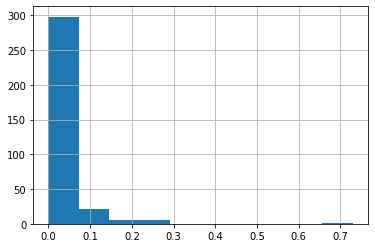

In [36]:
idx = Subclass_Exp_DF.index.values[9]
print(idx)
Subclass_Exp_DF.loc[idx, :].hist()

In [25]:
Subclass_Exp_DF = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/subclass_MeanLogUMI.csv", index_col=0)


In [8]:
Subclass_Z1 = Z1Conversion(Subclass_Exp_DF, "dat/SC_UMI_Mats/Subclass_UMI_Z1Mat.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in scalar divide
  z = (x - mean)/std


In [18]:
def ZscoreConverting_V2(values, mean=np.nan, std=np.nan, low_exp = 0, min_z=-5): 
    """
    Convert values to z-scores with special handling for zeros:
    - Build distribution using only non-zero values
    - Set minimum z-score to min_z (default -5)
    - Set all zero expressions to min_z (default -5)
    
    Args:
        values: Array-like input values
        mean: Optional pre-computed mean
        std: Optional pre-computed standard deviation
        min_z: Minimum z-score (default -5)
    Returns:
        numpy array of z-scores
    """
    # Convert to numpy array and identify non-zero values
    values = np.array(values)
    non_zero_mask = values >= low_exp
    non_zero_values = values[non_zero_mask]
    
    # If no non-zero values, return array of -5
    if len(non_zero_values) == 0:
        return np.full_like(values, min_z)
    
    # Calculate mean and std from non-zero values if not provided
    if mean != mean:  # Check for nan
        mean = np.mean(non_zero_values)
    if std != std:    # Check for nan
        std = np.std(non_zero_values)
        # Handle case where std is 0
        if std == 0:
            std = 1
    
    # Calculate z-scores
    zscores = np.full_like(values, min_z)  # Initialize with -5
    non_zero_zscores = (non_zero_values - mean) / std
    
    # Apply minimum threshold 
    non_zero_zscores = np.maximum(non_zero_zscores, min_z)
    
    # Put non-zero z-scores back in original positions
    zscores[non_zero_mask] = non_zero_zscores
    
    return zscores

def Z1Conversion(ExpMat, outname="test.z1.mat"):
    Z_mat = []
    for g, row in ExpMat.iterrows():
        tmp = ZscoreConverting(row.values)
        Z_mat.append(tmp)
    Z_mat = np.array(Z_mat)
    CT_Z1_DF = pd.DataFrame(data=Z_mat, index=ExpMat.index.values, 
                            columns=ExpMat.columns.values)
    CT_Z1_DF.to_csv(outname)
    return CT_Z1_DF

def Z1Conversion_V2(ExpMat, outname="test.z1.mat", low_exp = 0, min_z=-5):
    """
    Convert expression matrix to z-scores with zero handling
    
    Args:
        ExpMat: pandas DataFrame with genes as rows and cell types as columns
        outname: output file name for saving results
        
    Returns:
        pandas DataFrame with z-scores
    """
    Z_mat = []
    for g, row in ExpMat.iterrows():
        tmp = ZscoreConverting_V2(row.values, min_z=min_z)
        Z_mat.append(tmp)
    
    Z_mat = np.array(Z_mat)
    CT_Z1_DF = pd.DataFrame(data=Z_mat, 
                           index=ExpMat.index.values,
                           columns=ExpMat.columns.values)
    
    CT_Z1_DF.to_csv(outname)
    return CT_Z1_DF


In [19]:
# Check how 0-expressed genes specificity score 
HumanCT_Z1 = Z1Conversion_V2(Subclass_Exp_DF, min_z=-5)
max_Z, min_Z = 5, -5
HumanCT_Z1 = HumanCT_Z1.clip(upper=max_Z, lower=min_Z)
HumanCT_Z1.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/subclass_MeanLogUMI.Z1.clip5.csv")

In [20]:
# Check how 0-expressed genes specificity score 
HumanCT_Z1 = Z1Conversion_V2(Subclass_Exp_DF, min_z=-5)
max_Z, min_Z = 3, -3
HumanCT_Z1 = HumanCT_Z1.clip(upper=max_Z, lower=min_Z)
HumanCT_Z1.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/subclass_MeanLogUMI.Z1.clip3.csv")

In [21]:
Cluster_Exp_DF = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/cluster_MeanLogUMI.csv", index_col=0)

In [22]:
MouseCluster_CT_Z1 = Z1Conversion_V2(Cluster_Exp_DF, min_z=-5)
max_Z, min_Z = 5, -5
MouseCluster_CT_Z1 = MouseCluster_CT_Z1.clip(upper=max_Z, lower=min_Z)
MouseCluster_CT_Z1.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/cluster_MeanLogUMI.Z1V2.clip5.csv")

In [23]:
MouseCluster_CT_Z1 = Z1Conversion_V2(Cluster_Exp_DF, min_z=-3)
max_Z, min_Z = 3, -3
MouseCluster_CT_Z1 = MouseCluster_CT_Z1.clip(upper=max_Z, lower=min_Z)
MouseCluster_CT_Z1.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/cluster_MeanLogUMI.Z1V2.clip3.csv")

In [ ]:
Subclass_Exp_DF = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/subclass_MeanLogUMI.csv", index_col=0)

In [26]:
col_sums = Subclass_Exp_DF.sum(axis=0)
sum_mean = col_sums.mean()

# Normalize each column to have the same sum (1000 * mean)
target_sum = 1000 * sum_mean
normalized_expr = Subclass_Exp_DF.div(col_sums, axis=1) * target_sum

In [27]:
# Calculate total expression sum across cell types for each gene
total_exp_per_gene = normalized_expr.sum(axis=1)

# Divide each expression value by the total for that gene to get fraction
specificity_scores = normalized_expr.div(total_exp_per_gene, axis=0)
specificity_scores.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/subclass_MeanLogUMI.specificity.csv")